This is Part II of the notebook with some experiments in using the Yamnet pre-trained neural network for classifying and evaluating bird audio recordings from the Cacophony project.

See [part I](Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for a full background

Quentin McDonald <br>
August  2021

In [1]:
import csv
import io
import os
import os.path
import glob
import datetime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patches
from IPython import display
import pydub
from scipy import signal
import pandas as pd
from tqdm import notebook,trange
import pickle

# Common code moved to utils:
import utils

import score

In [2]:
SAMPLE_RATE = 16000 # Work at 16000 sampling rate
LOW_PASS_CUTOFF = 4000
HIGH_PASS_CUTOFF = 2000

In [3]:
model,class_names = utils.load_model_and_class_names()

2021-09-17 11:16:22.744321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-17 11:16:28.808172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<H2> Investigating the Yamnet scoring in more detail </H2>

The techniques in part I of the notebook generally used the idea that bird-like sounds would have to appear in the top 2 scores for any frame in the audio file. Since it appears Yamnet is able to produce multiple classifications for each signal and the classifcations are not normalized this may not be the best approach. Instead it seems like it would be worthwhile looking at the classifcations in more detail. This is especially the case since some of the classifications are overlapping and we often see our bird sounds also reported as "animals" or "wild animals".

Some useful ideas and code fragments are from [this article](https://analyticsindiamag.com/guide-to-yamnet-sound-event-classifier/)


In [4]:
def plot_yamnet_scores(filename,model,class_names,
                      low_pass_cutoff = None, 
                      high_pass_cutoff = None,
                      top_n_classifications = 10,
                      start_time = 0,
                      end_time = 40,
                      offset = 0):
    """
    Read audio data from the wave file given by "filename"
    Run the sound against the model and plot the top N classes that scored along with the waveform.
    
    Data will only be read from start_time to end_time
    """

    wave_data = utils.load_audio_16k_mono(filename, out_sample_rate=SAMPLE_RATE,
                                             start_time=start_time,end_time=end_time)   
    
    if low_pass_cutoff != None:
        wave_data =utils.butter_lowpass_filter( wave_data, low_pass_cutoff, SAMPLE_RATE, order=5)
    
    if high_pass_cutoff != None:
        wave_data =utils.butter_highpass_filter( wave_data, high_pass_cutoff, SAMPLE_RATE, order=5)
        
   
    # Evaluate the data against the model:
    scores, embeddings, spectrogram = model(wave_data[int(offset*SAMPLE_RATE):])
    
    scores_np = scores.numpy()
    mean_scores = np.mean(scores_np, axis=0)
    
    top_class_indices = np.argsort(mean_scores)[::-1][:top_n_classifications]
    
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    
    x = np.arange(len(wave_data),dtype='float32')
    x = x/SAMPLE_RATE
    x = x + start_time
    
    plt.plot(x,wave_data,c='#6655DD')
    plt.title("Wave data from {}".format(filename))
    plt.ylabel("Amplitude")
    
    plt.subplot(2, 1, 2)
    im = plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='plasma')
    fig.colorbar(im, location='bottom',  shrink=1.0)

    patch_padding = (0.025 / 2) / 0.01
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    yticks = range(0, top_n_classifications, 1)
    plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n_classifications, 0])) 
    plt.grid(b=None)
    plt.ylabel("Class")
    plt.show()
    return wave_data

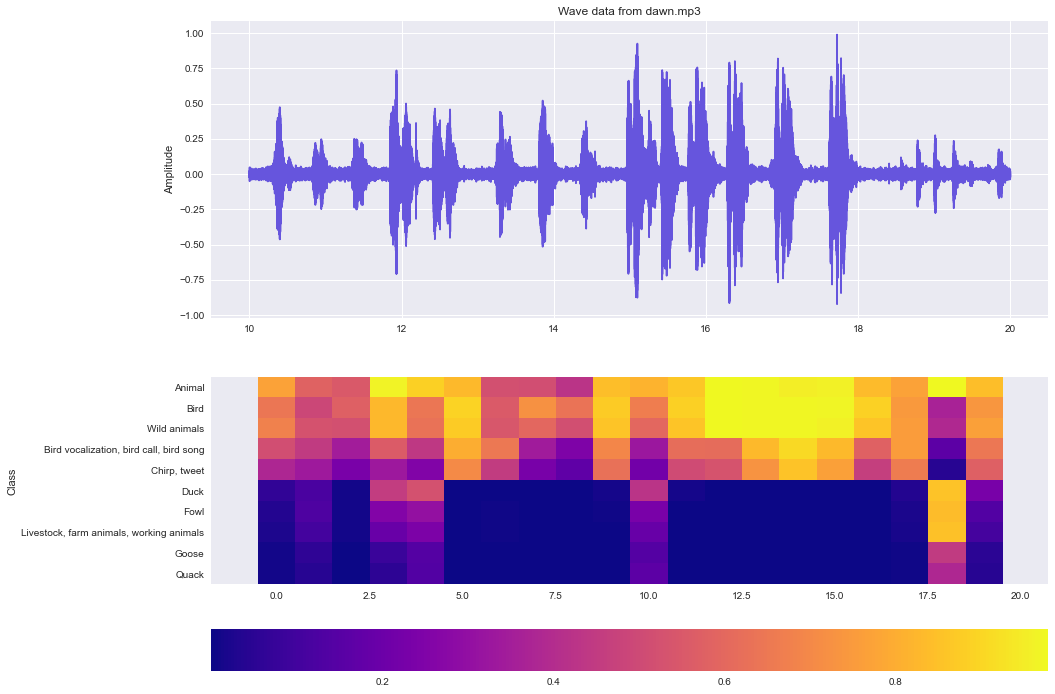

In [5]:
dawn_data = plot_yamnet_scores("dawn.mp3", model, class_names, 
                               low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF,
                              start_time = 10, end_time=20)
display.Audio(dawn_data,rate=SAMPLE_RATE)

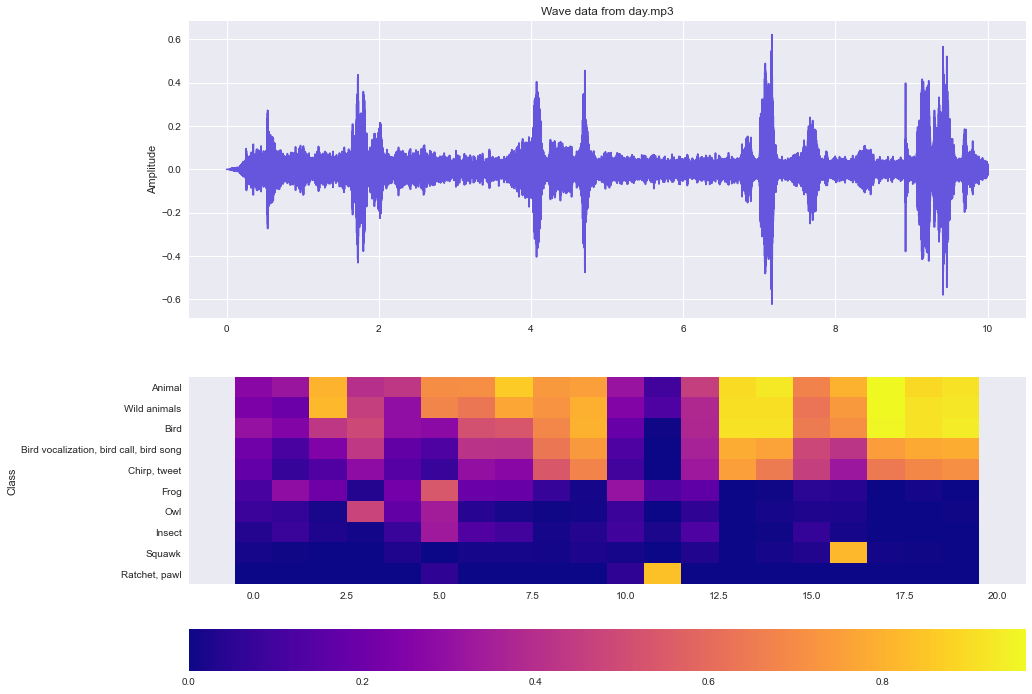

In [6]:
day_data = plot_yamnet_scores("day.mp3", model, class_names, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF,
                             start_time = 0, end_time = 10)
display.Audio(day_data,rate=SAMPLE_RATE)

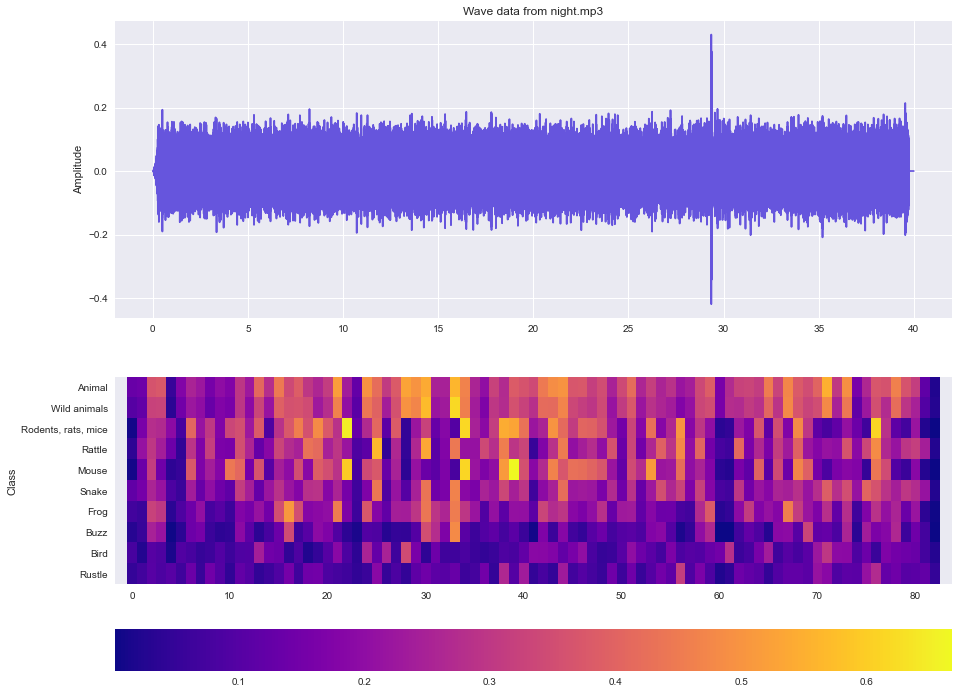

In [7]:
night_data = plot_yamnet_scores("night.mp3", model, class_names, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF,
                             start_time = 0, end_time = 40)
display.Audio(night_data,rate=SAMPLE_RATE)

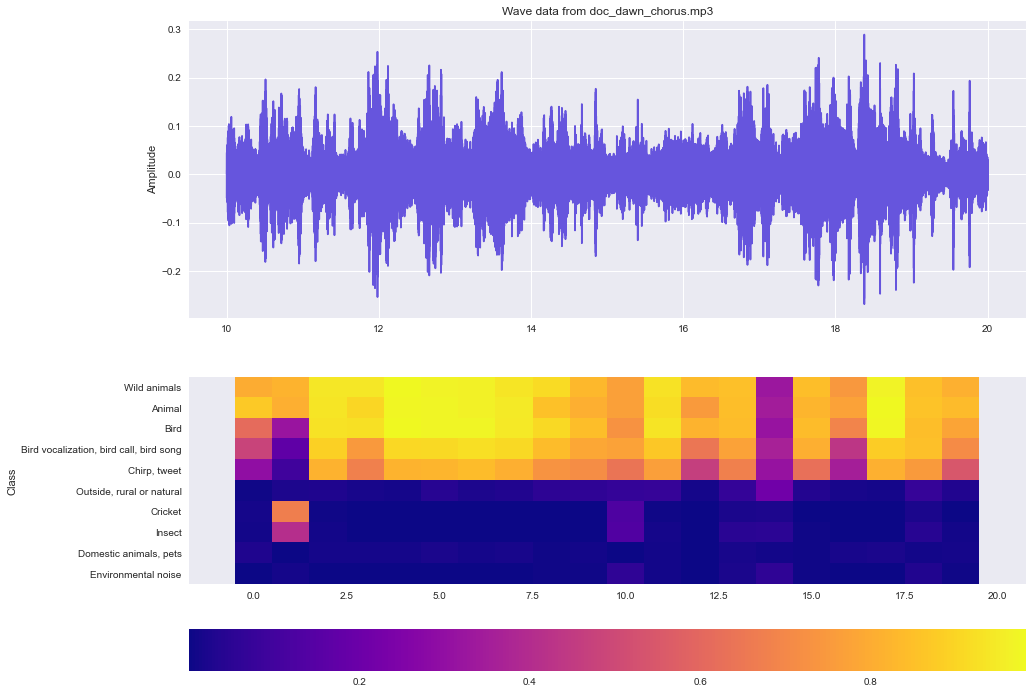

In [8]:
dawn_chorus_data = plot_yamnet_scores("doc_dawn_chorus.mp3", model, class_names, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF,
                             start_time =10, end_time = 20)
display.Audio(dawn_chorus_data,rate=SAMPLE_RATE)

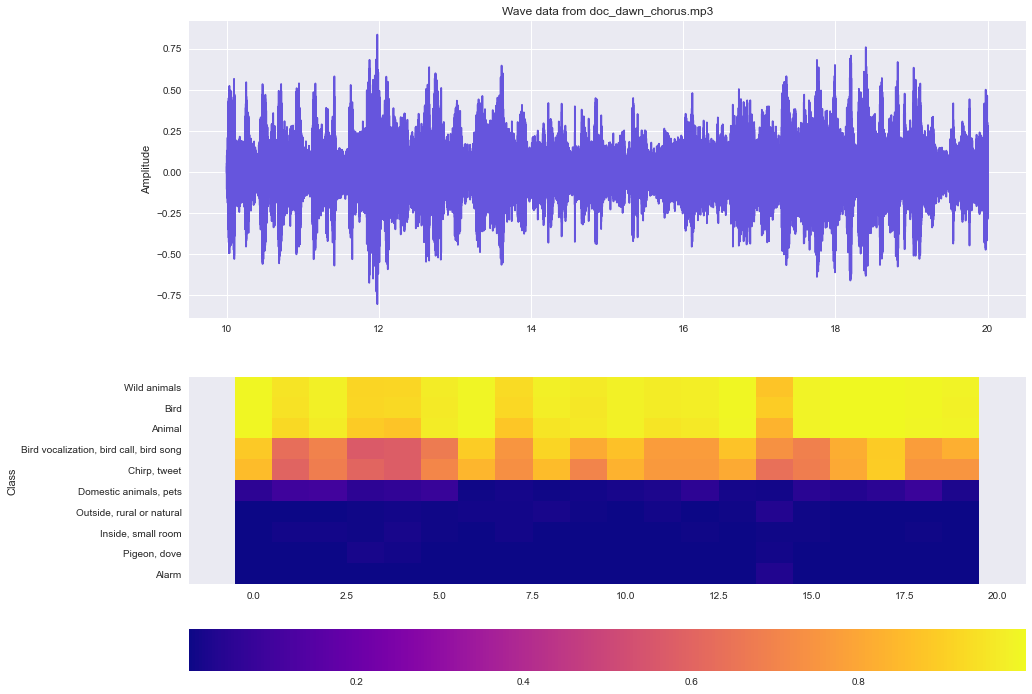

In [8]:
dawn_chorus_data = plot_yamnet_scores("doc_dawn_chorus.mp3", model, class_names, 
                              low_pass_cutoff=None,high_pass_cutoff=None,
                             start_time = 10, end_time = 20)
display.Audio(dawn_chorus_data,rate=SAMPLE_RATE)

<H2> Threshold based scoring </H2>
Based on the above it seems worth trying a threshold based scoring where if any of the Bird-like classes score above a certain threshold it will be counted as a "bird" instance in that frame

In [9]:
BIRDS_CLASSES = utils.BIRDS_CLASSES

In [10]:
def score_audio_file(filename,
                      model, 
                      bird_classes,
                      num_offsets = 5,
                      low_pass_cutoff = None, 
                      high_pass_cutoff = None,
                      score_threshold = 0.6,
                      verbose=False):
    """
    Read audio data from the wave or mp3 file given by "filename"
    If high_pass_cutoff and low_pass_cutoff are not None then lowpass and/or highpass filtering will 
    be performed
    Run the sound data against the model and count the number of bird like sounds. Run the model num_offsets
    time, offsetting the start of the file by 1/num_offsets of a frame each time
    If a bird like sound has a threshold greater than
    Return the average bird count
    """

    wave_data = utils.load_audio_16k_mono(filename, out_sample_rate=SAMPLE_RATE)   
    
    if low_pass_cutoff != None:
        wave_data =utils.butter_lowpass_filter( wave_data, low_pass_cutoff, SAMPLE_RATE, order=5)
    
    if high_pass_cutoff != None:
        wave_data =utils.butter_highpass_filter( wave_data, high_pass_cutoff, SAMPLE_RATE, order=5)
        
   
    sum_counts = 0
    offset =0 
    
    for i in range(num_offsets):
        
        scores, embeddings, spectrogram = model(wave_data[i*offset:])
        scores_np = scores.numpy()
        if i == 0:
            # Set some parameters based on the first model applicatoin
            num_frames = len(scores_np)
            offset = int((len(wave_data)/num_frames)/num_offsets)
        
        
        scores_above_threshold  = scores_np[:,:] > score_threshold
        
        # Count the number of birds in each frame
        count = 0
        for frame in range(scores_np.shape[0]):
             if np.any(scores_above_threshold[frame,bird_classes]):
                    count += 1
                  
                
        sum_counts += count
        
        if verbose:
            print("{:2d} Offset = {:5.3f}, Offset count = {:3d}".format(i,(i*offset)/SAMPLE_RATE,count))
        
    
    # Score is averaged over all the offset applications of the model and then divided by the number of frames
    # to give a value in the range 0-1
    
    return (sum_counts/float(num_offsets))/float(num_frames)

In [11]:
files = ["dawn.mp3","day.mp3","night.mp3","doc_dawn_chorus.mp3"]

thresh_scores = []

for f in files:    
    thresh_score = score_audio_file(f, model,BIRDS_CLASSES,score_threshold=0.4,low_pass_cutoff=LOW_PASS_CUTOFF,
                high_pass_cutoff=HIGH_PASS_CUTOFF, verbose=False, num_offsets=3)
    thresh_scores.append(thresh_score)
    

data_dict = {
    "Filename": files,
    "Score": thresh_scores 
}
pd.DataFrame.from_dict(data_dict)

Filename     Score
0             dawn.mp3  0.771084
1              day.mp3  0.433735
2            night.mp3  0.004016
3  doc_dawn_chorus.mp3  0.791165

These values also look reasonable. Now try this with no filtering:

In [13]:
thresh_scores = []
for f in files:    
    thresh_score = score_audio_file(f, model,BIRDS_CLASSES,score_threshold=0.4,low_pass_cutoff=None,
                high_pass_cutoff=None)
    thresh_scores.append(thresh_score)
    

data_dict = {
    "Filename": files,
    "Score": thresh_scores 
}
pd.DataFrame.from_dict(data_dict)

Filename     Score
0             dawn.mp3  0.431325
1              day.mp3  0.072289
2            night.mp3  0.000000
3  doc_dawn_chorus.mp3  0.973494

Band pass filtering appears to give better results for the quieter real world sample, even if the noiser DOC sample has its score reduced

<b> Test external scoring module: </b> <br>
Also compare with versions of the files normalized with Audacity to a peak db of -1. Since the file reading is now standardizing the average amplitude there is little difference between the externally normailised and non-processed files.

In [15]:
files = ["dawn.mp3","dawn_norm.mp3",
         "day.mp3","day_norm.mp3",
         "night.mp3","night_norm.mp3",
         "doc_dawn_chorus.mp3","doc_dawn_chorus_norm.mp3"]

top_class_scores = []
thresh_scores = []

for f in files:    
    top_class_score,thresh_score  = score.score_audio_file(f, model,BIRDS_CLASSES,top_k_scores=3, score_threshold=0.4,low_pass_cutoff=LOW_PASS_CUTOFF,
                high_pass_cutoff=HIGH_PASS_CUTOFF, verbose=False, sample_rate = SAMPLE_RATE, num_offsets=3)
    top_class_scores.append(top_class_score)
    thresh_scores.append(thresh_score)
    

data_dict = {
    "Filename": files,
    "Top Class Score": top_class_scores,
    "Threshold Score": thresh_scores
}
pd.DataFrame.from_dict(data_dict)

Filename  Top Class Score  Threshold Score
0                  dawn.mp3         0.827309         0.771084
1             dawn_norm.mp3         0.823293         0.795181
2                   day.mp3         0.554217         0.433735
3              day_norm.mp3         0.566265         0.429719
4                 night.mp3         0.076305         0.004016
5            night_norm.mp3         0.032129         0.000000
6       doc_dawn_chorus.mp3         0.891566         0.791165
7  doc_dawn_chorus_norm.mp3         0.855422         0.791165

<H2> Scoring a day's worth of recordings by threshold </H2>

In [16]:
def score_files_in_directory(directory, low_pass_cutoff=None, high_pass_cutoff=None,
                            score_threshold=0.4, num_offsets=3):

    """
    Create a Yamnet score for each file in the given directory
    Plot those against the time of the recording 
    If there's a "recordings.csv" in the directory then read that and use that to read cacophony scores
    Usually the recordings (in wav format) will represent an entire day's worth of recording
    
    """
    files = glob.glob("{}/*.mp3".format(directory))
    scores = []
    dates = []
    
    cacophony_indices = utils.read_cacophony_indices(directory)
    
    for f in sorted(files):
        score = score_audio_file(f, model,BIRDS_CLASSES,score_threshold=score_threshold,low_pass_cutoff=low_pass_cutoff,
                high_pass_cutoff=high_pass_cutoff, num_offsets=num_offsets)
        dates.append(utils.filename_to_date(f))
        scores.append(score)
       
    fig = plt.figure(2,figsize=(15,10),dpi=300)
    ax = fig.subplots(1)
    ax.set_title("Yamnet derived scores for data recorded {}".format(directory))
    ax.set_xlabel("Time")
    ax.set_ylabel("Score")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    lns1=ax.plot(dates,scores,c='#AA55AA',linewidth=3,label='Yamnet Index')
    
    
    if len(cacophony_indices) == len(scores):
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        lns2 = ax2.plot(dates,cacophony_indices,c='#AAAA55',linestyle='dotted',label='Cacophony Index')
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.set_ylabel("Cacophony Index")
        
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc=0)
    plt.show()

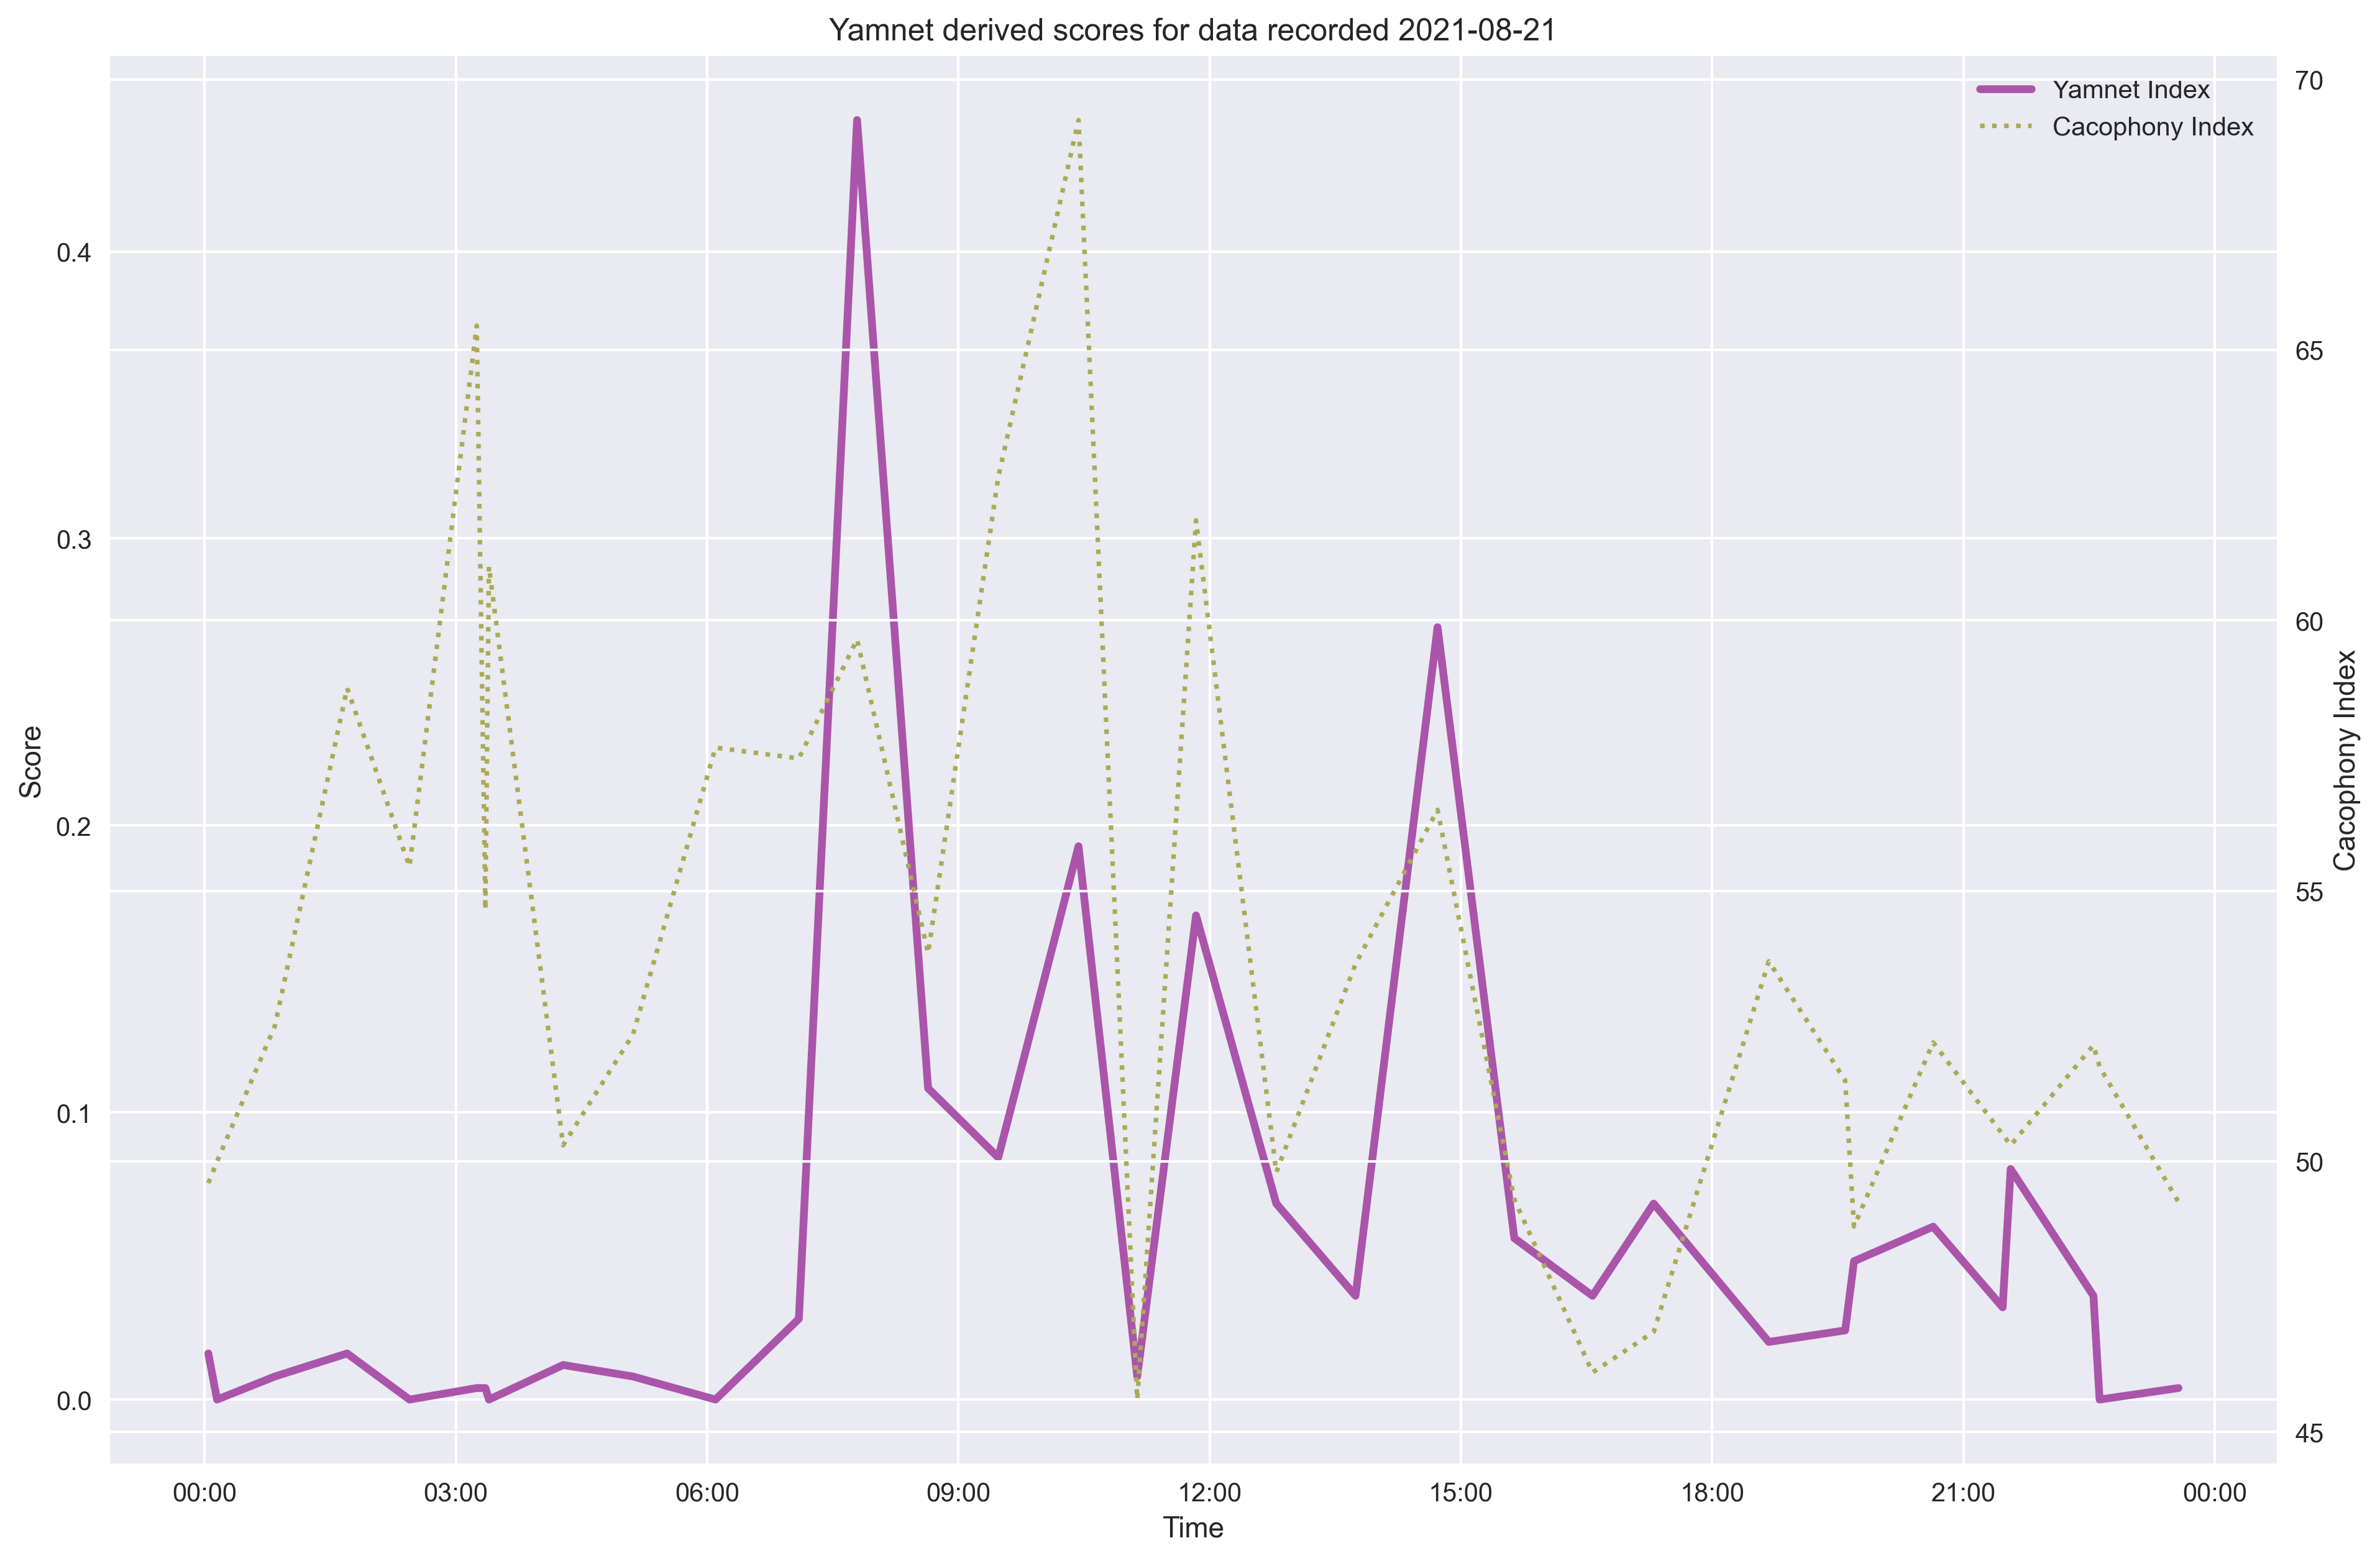

In [17]:
score_files_in_directory("2021-08-21", low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF)

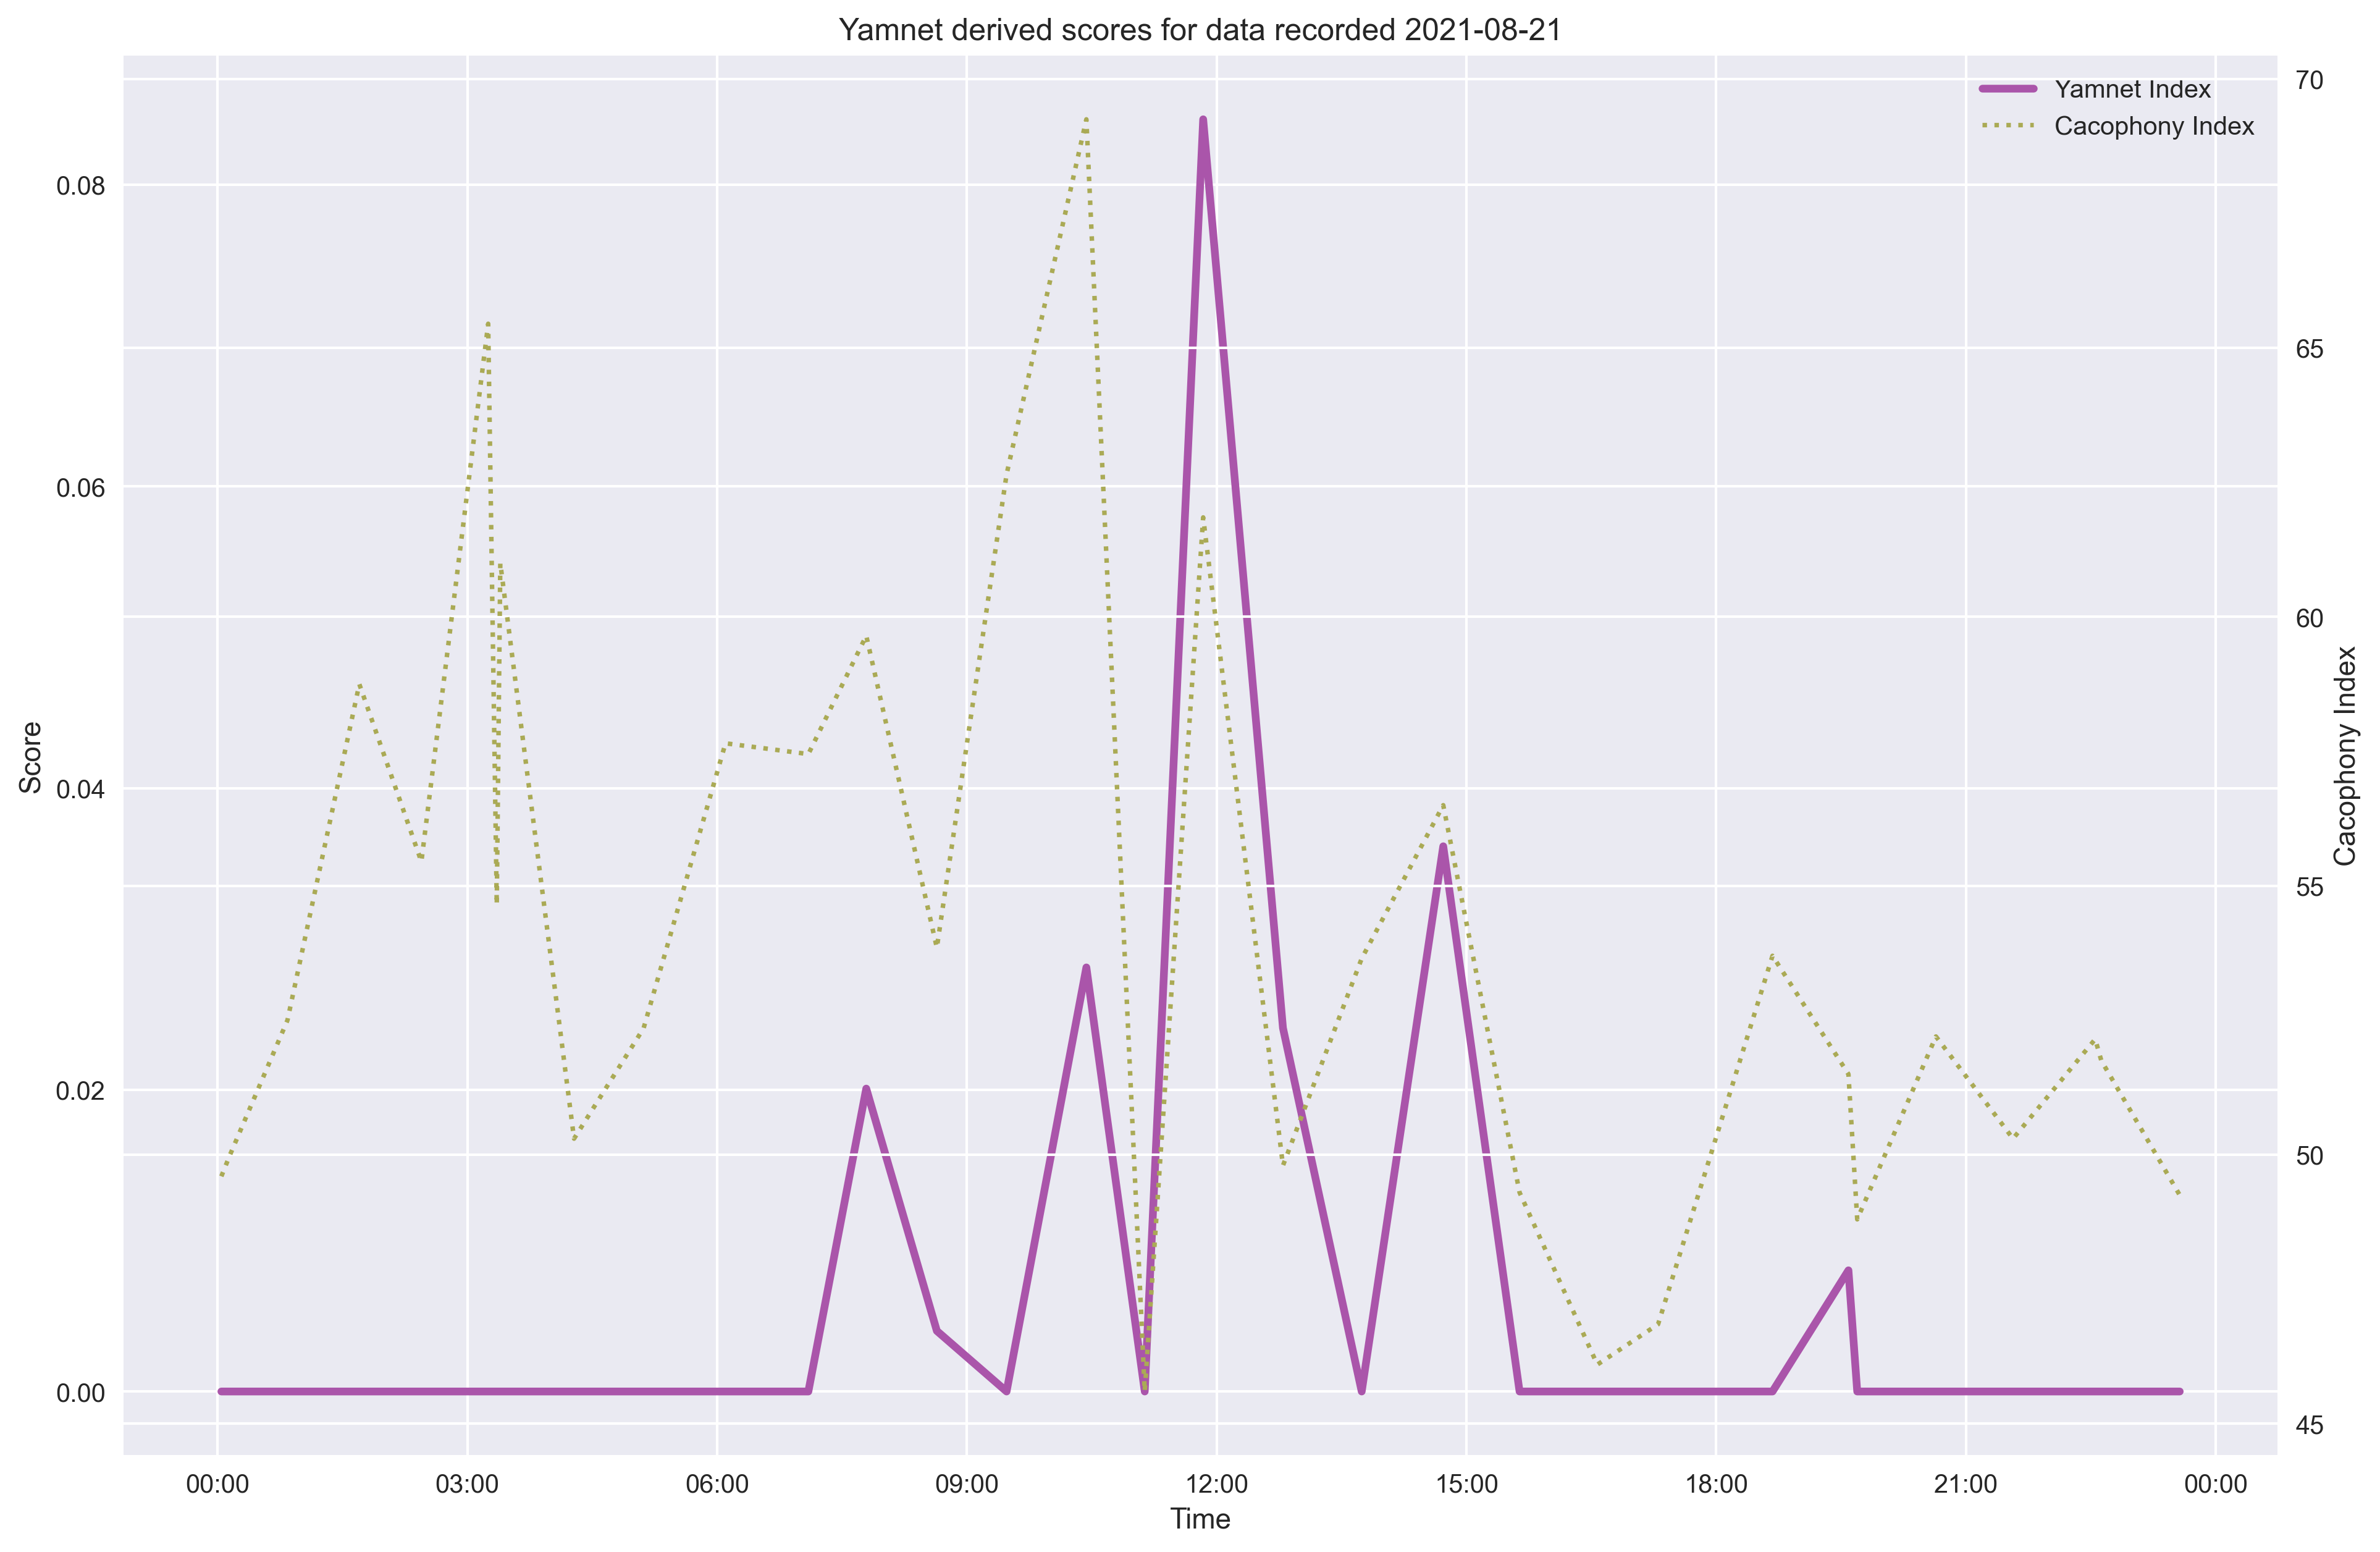

In [18]:
score_files_in_directory("2021-08-21", low_pass_cutoff=None,high_pass_cutoff=None)

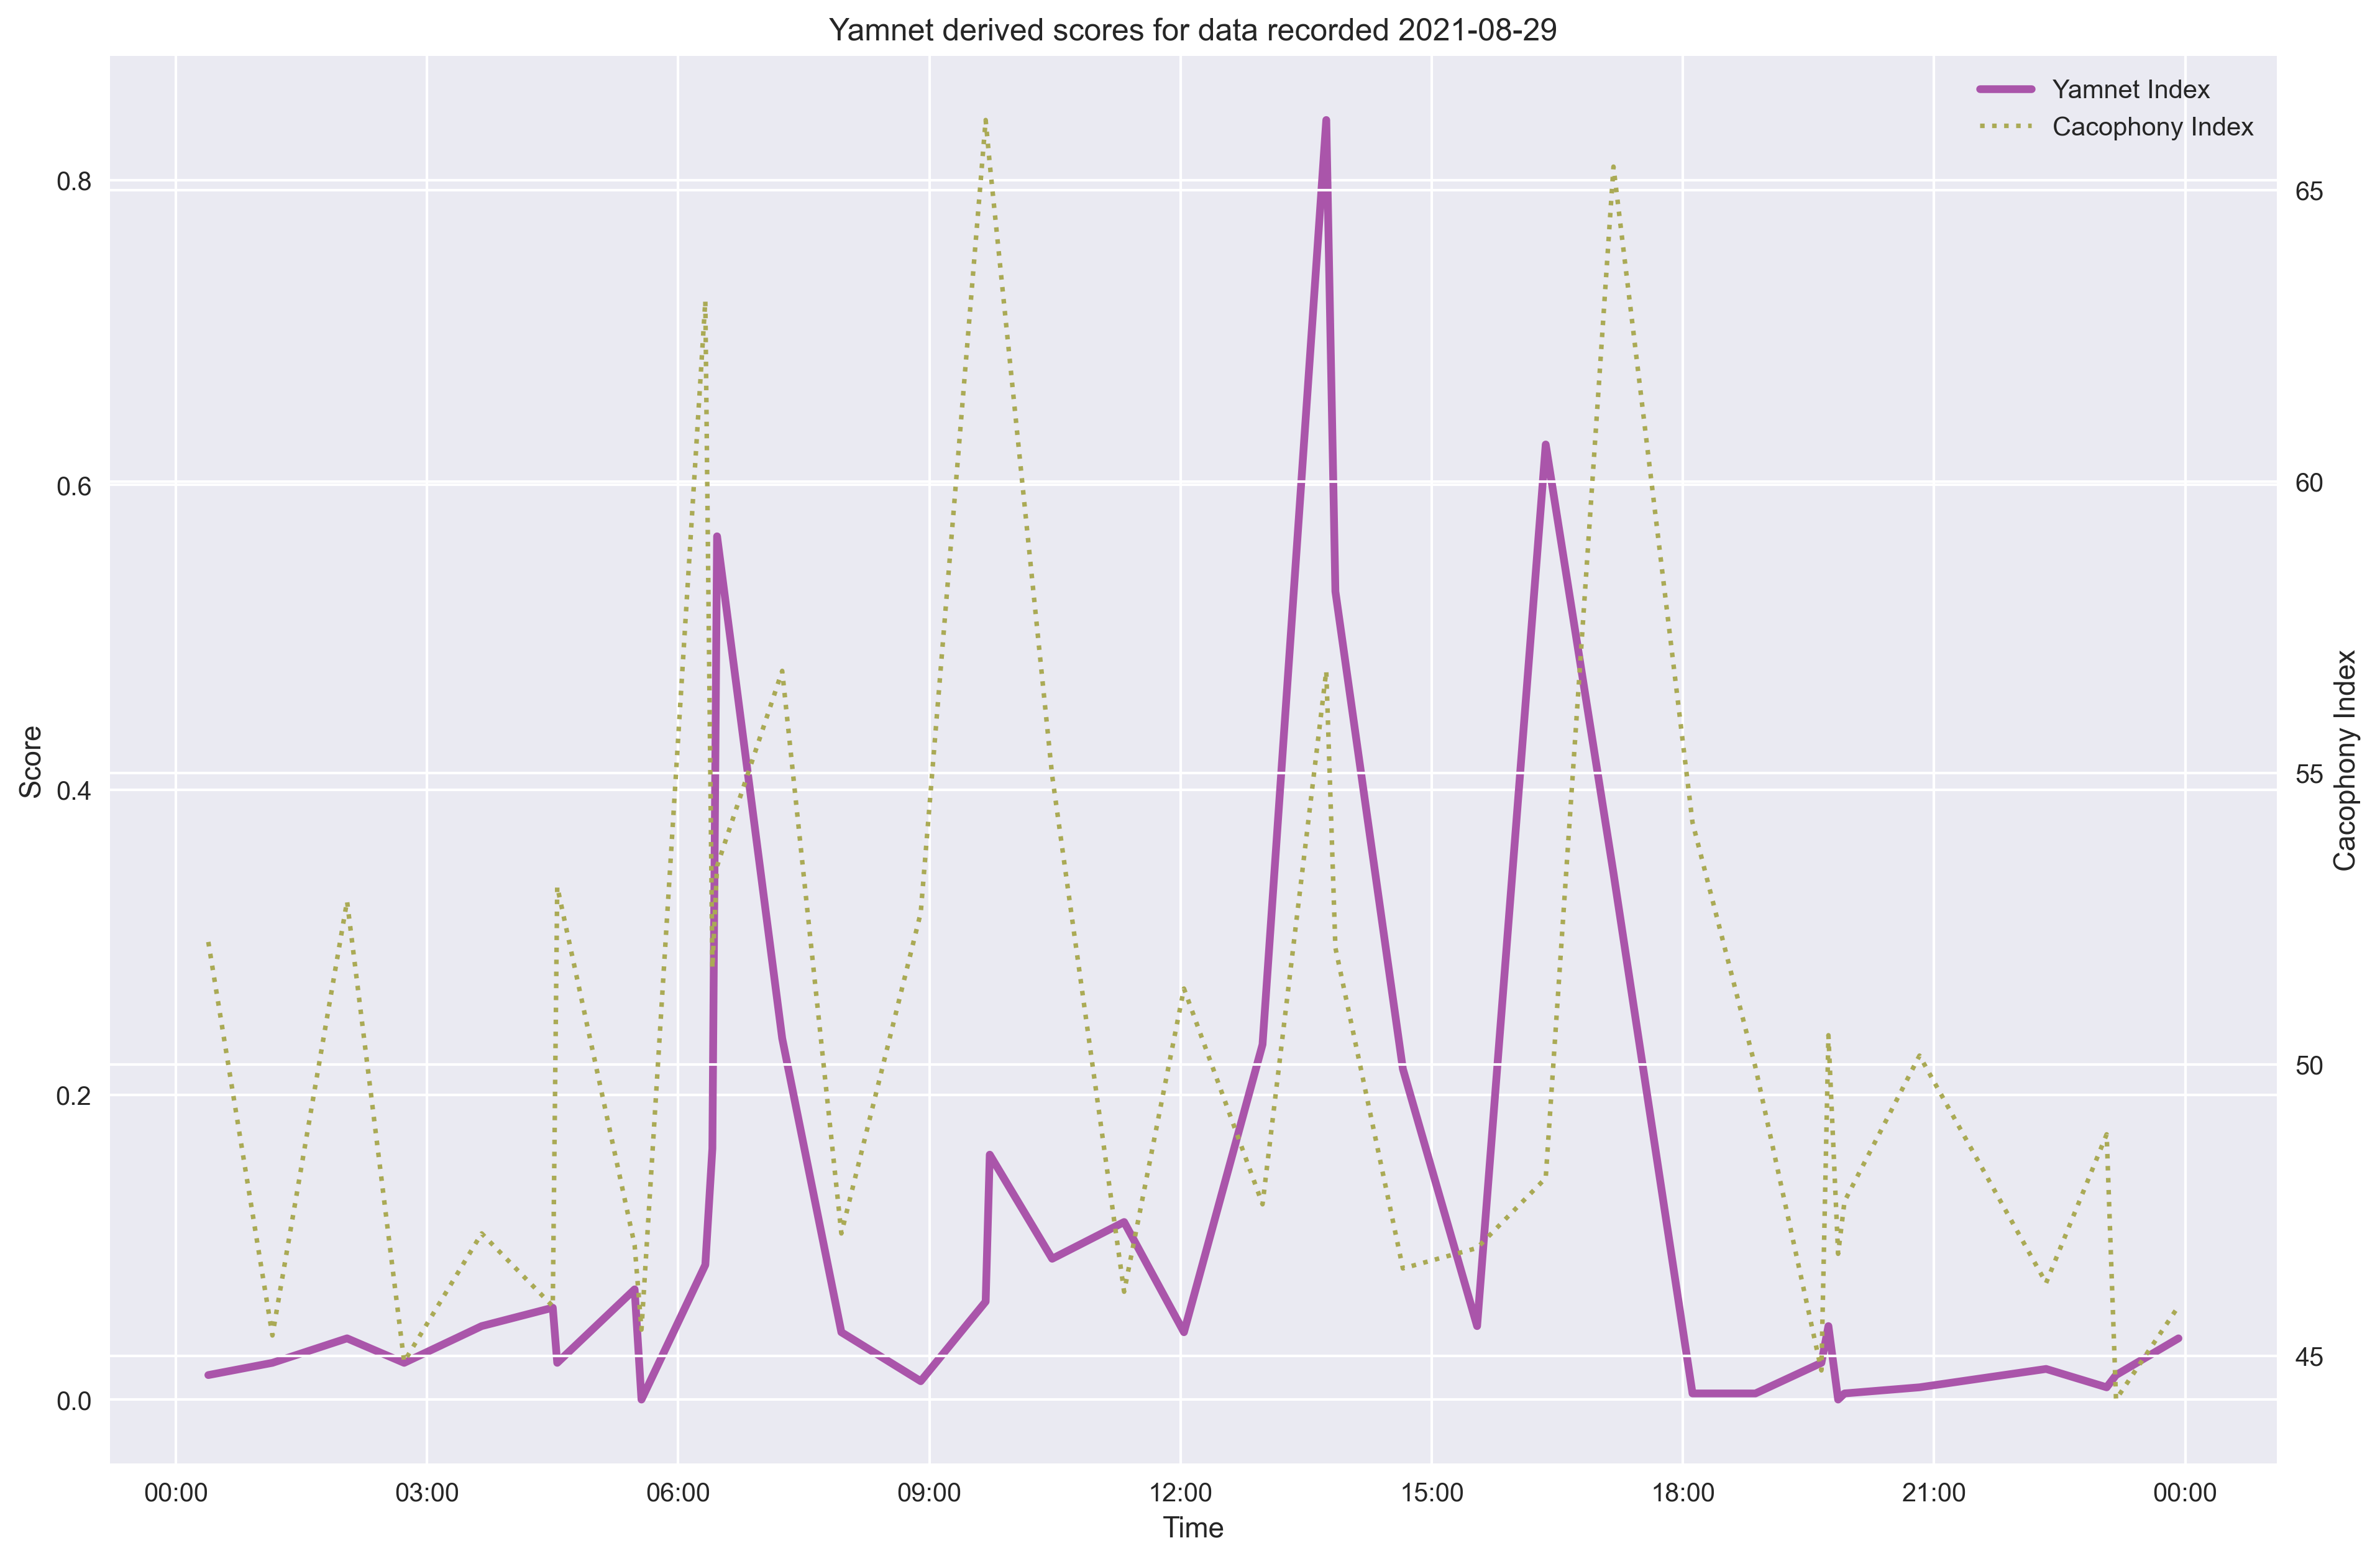

In [19]:
score_files_in_directory("2021-08-29", low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF)

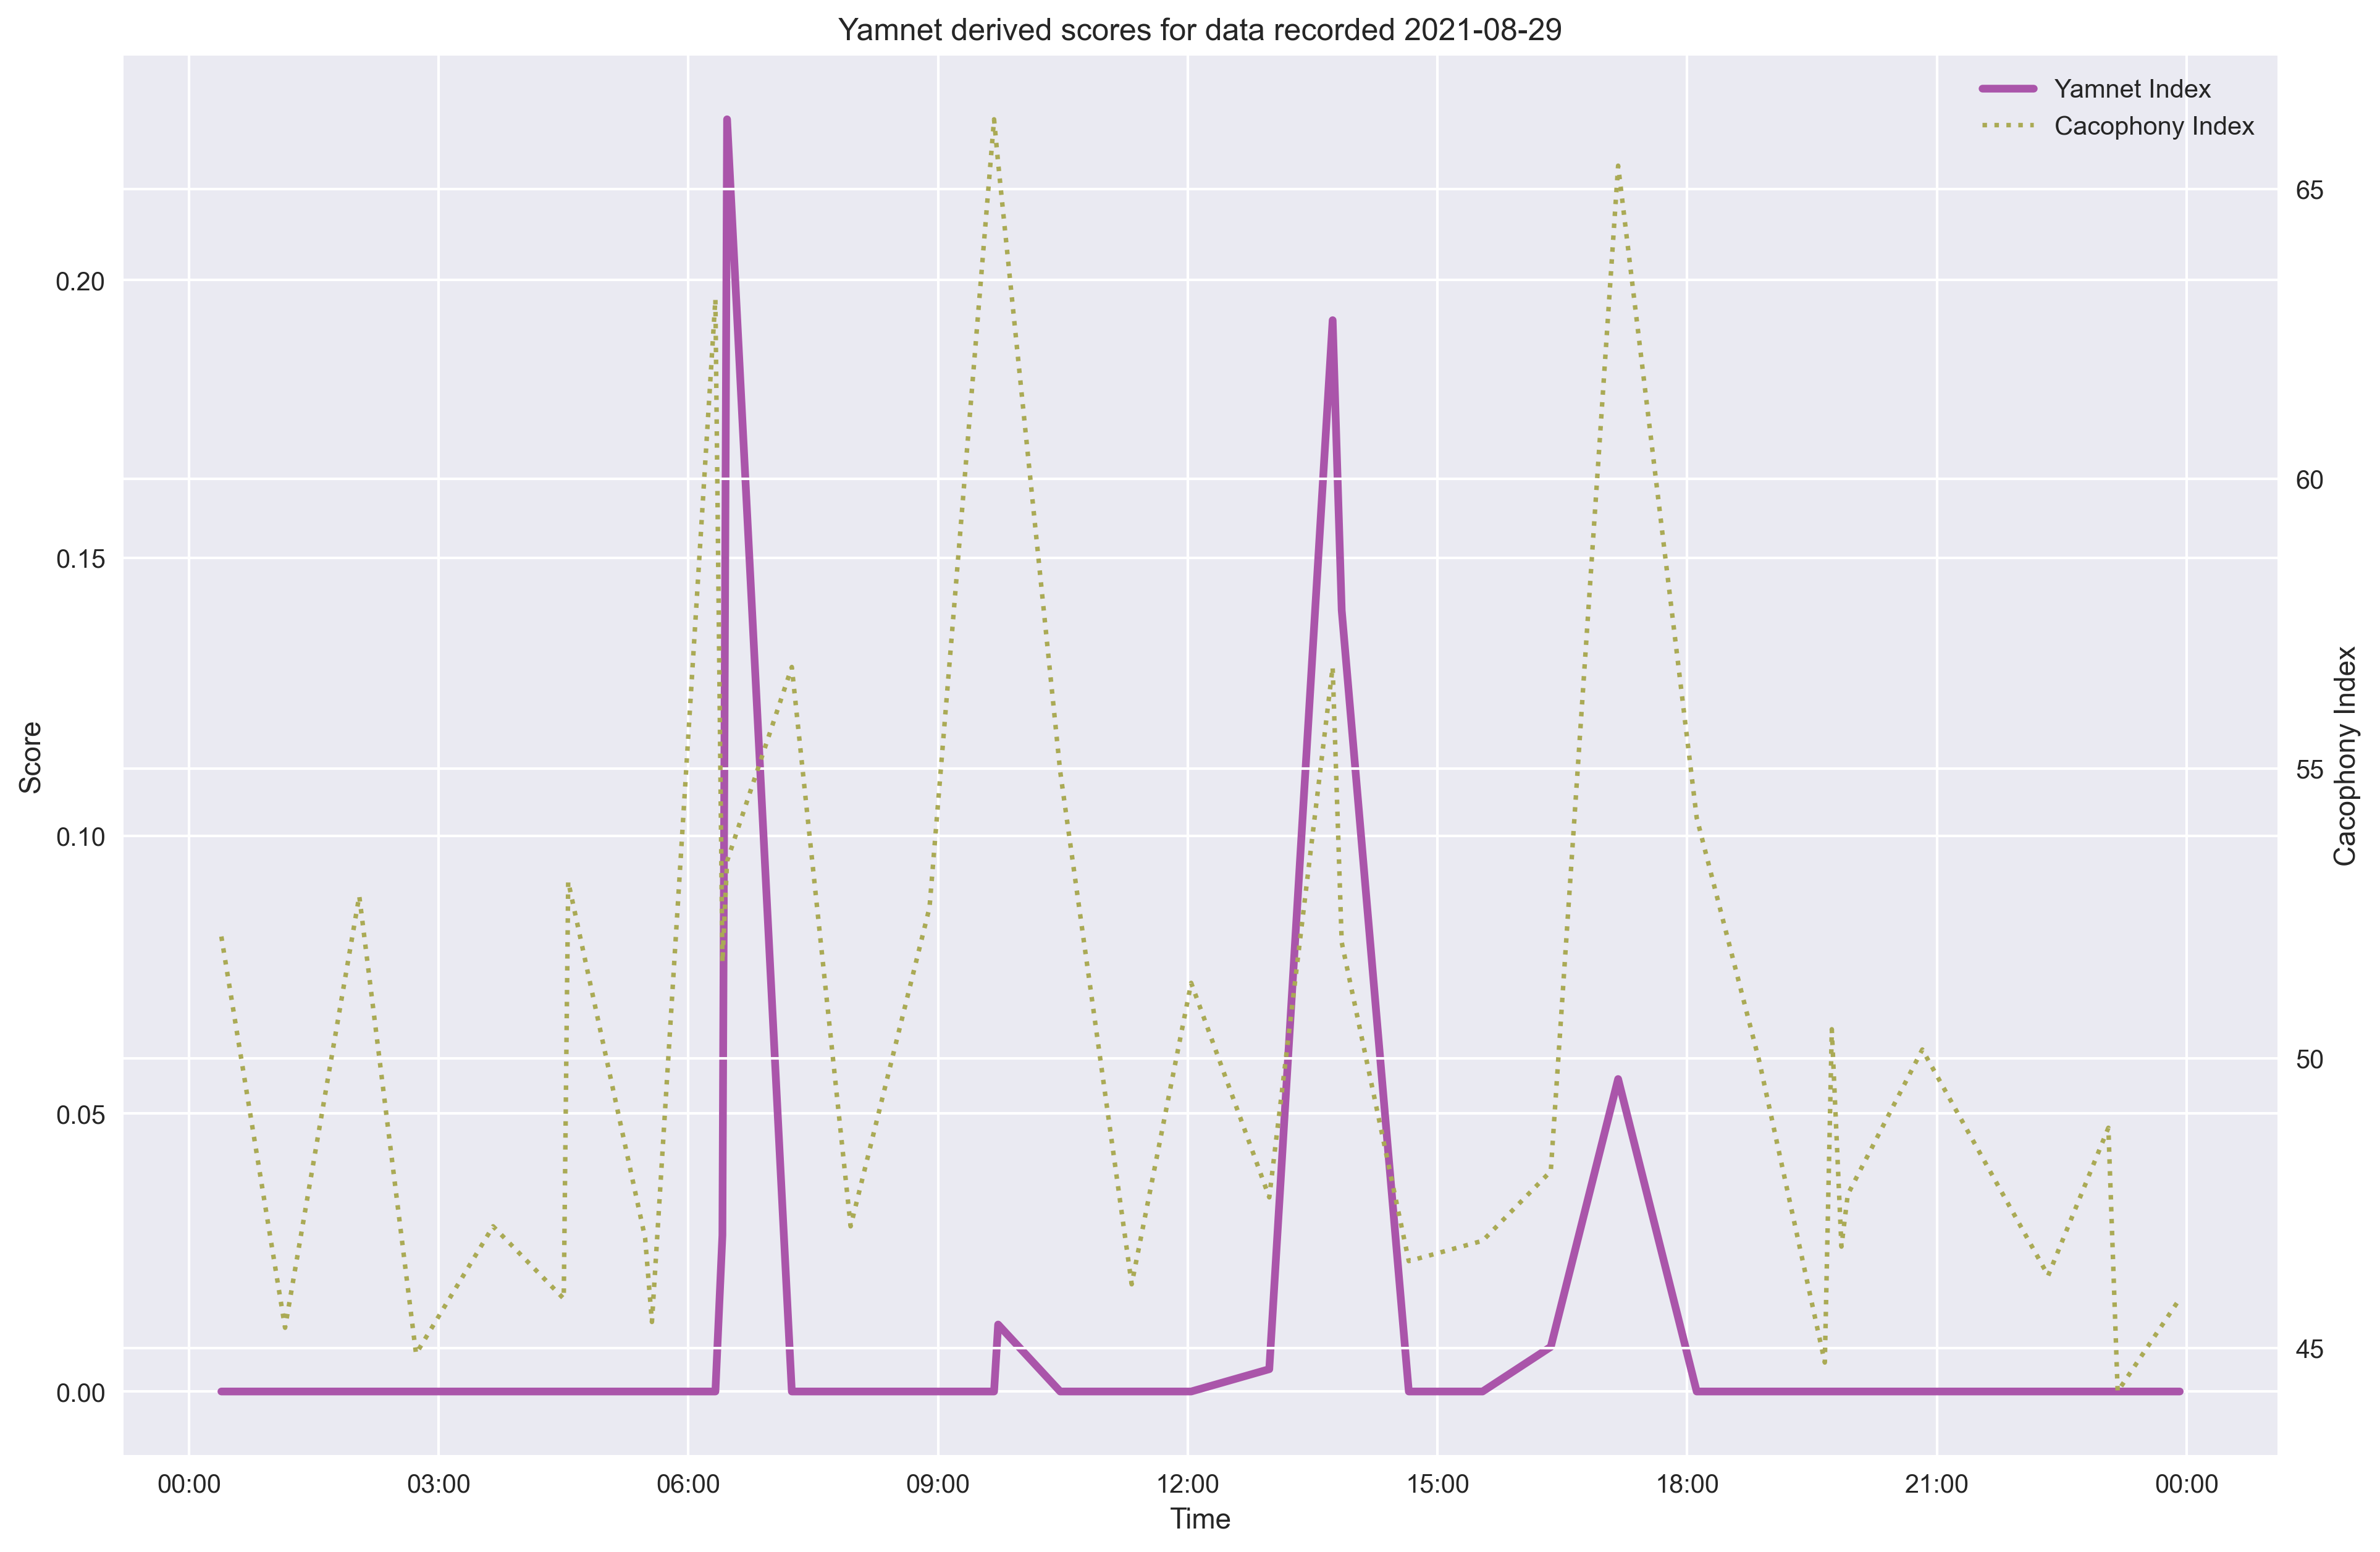

In [20]:
score_files_in_directory("2021-08-29", low_pass_cutoff=None,high_pass_cutoff=None)

<H2> Scoring by Threshold - Conclusions </H2>

Scoring by threshold appears to be more sensitive to both the nature of filtering used and the overall volume of the audio track. This may give a better sense of the "quantity" of bird life but testing with larger amounts of data will be needed